In [43]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,accuracy_score

In [44]:
#数据集
def getTrainAndTestSeqs(inPath, test_ratio=0.1):
    seqs = np.load(inPath)

    allItems = set()
    for seq in seqs:
        allItems|=set(seq[:-1])

    np.random.shuffle(seqs)
    split_number = int(len(seqs)*test_ratio)
    test = seqs[:split_number]
    train = seqs[split_number:]
    return train, test, allItems

train, test, allItems = getTrainAndTestSeqs('data_set/ml-latest-small/seqs.npy')
print(len(allItems)) #6809

#构建item2id
item2id = {}
for i, item in enumerate(allItems):
    item2id[item] = i+2#0,1已经被最后一列占用了

print(f"item2id is {item2id}")
#将第7列也放进去
item2id[0] = 0
item2id[1] = 1
print(f"item2id is {item2id}")


#构建id2item
id2item = {v:k for k, v in item2id.items()}

#将id转为item
def id2itemFun(seq):
    return [id2item[id] for id in seq]

#将item转换为id
def item2idFun(seq):
    return [item2id[item] for item in seq]

#将对应的item转为id
train = np.array([item2idFun(seq) for seq in train])
test = np.array([item2idFun(seq) for seq in test])


#训练数据 (39949, 5) (39949, 2)
train_x = train[:, :-2] #5344 5352 5410 5418 5425 <class 'numpy.ndarray'>
train_y = train[:, 5:]# 906 0 <class 'numpy.ndarray'>

#测试数据 (4438, 5) (4438, 2)
test_x = test[:, :-2] #[3294 4969 1198 2820 6772] <class 'numpy.ndarray'>
test_y = test[:, 5:] # 168 1 <class 'numpy.ndarray'>

#设置超参数
batch_size = 128


#使用dataset和dataloader包装数据集
train_dataset = TensorDataset(torch.from_numpy(np.int64(train_x)), torch.from_numpy(train_y))
test_dataset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) #[128, 5] [128, 2]
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)  #[128, 5] [128, 2]

6809
item2id is {2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 9: 7, 10: 8, 11: 9, 12: 10, 14: 11, 15: 12, 16: 13, 18: 14, 19: 15, 22: 16, 23: 17, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 31: 25, 32: 26, 33: 27, 34: 28, 35: 29, 36: 30, 37: 31, 39: 32, 40: 33, 42: 34, 44: 35, 45: 36, 46: 37, 47: 38, 48: 39, 50: 40, 52: 41, 54: 42, 55: 43, 57: 44, 60: 45, 61: 46, 62: 47, 64: 48, 66: 49, 67: 50, 68: 51, 70: 52, 71: 53, 72: 54, 73: 55, 75: 56, 76: 57, 77: 58, 78: 59, 80: 60, 81: 61, 82: 62, 83: 63, 84: 64, 85: 65, 87: 66, 88: 67, 89: 68, 90: 69, 91: 70, 92: 71, 93: 72, 94: 73, 95: 74, 96: 75, 97: 76, 98: 77, 100: 78, 102: 79, 103: 80, 104: 81, 105: 82, 106: 83, 107: 84, 109: 85, 110: 86, 112: 87, 113: 88, 114: 89, 115: 90, 116: 91, 118: 92, 119: 93, 122: 94, 125: 95, 126: 96, 127: 97, 128: 98, 129: 99, 130: 100, 131: 101, 132: 102, 133: 103, 134: 104, 135: 105, 137: 106, 138: 107, 139: 108, 141: 109, 142: 110, 143: 111, 144: 112, 145: 113, 146: 114, 147: 115, 148: 116, 149: 117, 150: 118, 1

In [45]:
#一个embedding层，一个gru网络，一个全连接层，输入一个seq_len*batch_size的矩阵
#输出一个seq_len*batch_size*item_size的矩阵，每个位置代表对应item的概率
#同时输出hidden，作为下一次的输入

class Model(nn.Module):
    def __init__(self, item_size, embedding_size, hidden_size, num_layers):
        super(Model, self).__init__()
        self.item_size = item_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(item_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, item_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.s = nn.Sigmoid()

    def forward(self, x, hidden, y6):

        x = self.embedding(x)
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)#128*6809 6809表示对应item的概率
        
        hn = torch.sum(hidden*y6, dim=0)
        hn = self.fc2(hn)
        hn = self.s(hn)#128*1
        
        return x, hn

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

#实例化模型
model = Model(len(allItems)+2, 128, 128, 1)

#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
bce_loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
#模型训练
epochs = 10
all_loss = []
c_loss = []
b_loss = []
for epoch in range(epochs):
    mall_loss = 0
    mc_loss = 0
    mb_loss = 0
    for x, y in train_loader:
        y6 = y[:, 0]
        y7 = y[:, 1]
        #print(x.size()) #[128, 5]
        #print(y.size()) #[128, 2]

        #初始化hidden
        hidden = model.init_hidden(batch_size)
        #print(hidden.size()) #[1, 128, 128]

        #前向传播
        output, hn = model(x, hidden, y6)
        # print(output.size()) #[128, 5, 6809]
        #print(hidden.size()) #[1, 128, 128]

        #计算损失
        loss1 = criterion(output[:, -1, :], y6.long())
        mc_loss += loss1.item()
        # print(hn)
        # print(y7)
        
        loss2 = bce_loss(hn, y7.view(-1, 1).float())
        mb_loss += loss2.item()
        loss = loss1* 0.5 + loss2* 0.5
        mall_loss += loss.item()

        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #输出损失值
    all_loss.append(mall_loss)
    c_loss.append(mc_loss)
    b_loss.append(mb_loss)
    print('epoch:{}, loss:{}, c_loss:{}, bce_loss:{}'.format(epoch, mall_loss, mc_loss, mb_loss))

    #保存模型
    torch.save(model.state_dict(), 'model.pth')

epoch:0, loss:7276.226057052612, c_loss:2596.3085713386536, bce_loss:11956.143539428711
epoch:1, loss:6914.179977416992, c_loss:2421.4459314346313, bce_loss:11406.914012908936
epoch:2, loss:6830.190625190735, c_loss:2337.840127468109, bce_loss:11322.541088104248
epoch:3, loss:6773.752411842346, c_loss:2253.289167881012, bce_loss:11294.215641021729
epoch:4, loss:7025.209100723267, c_loss:2290.408151626587, bce_loss:11760.010076522827
epoch:5, loss:6966.582332611084, c_loss:2248.063955307007, bce_loss:11685.100713729858
epoch:6, loss:6805.143272399902, c_loss:2167.8485321998596, bce_loss:11442.437995910645
epoch:7, loss:6706.65741443634, c_loss:2106.1977734565735, bce_loss:11307.117063522339
epoch:8, loss:6634.947360038757, c_loss:2034.6368355751038, bce_loss:11235.257892608643
epoch:9, loss:6905.8826360702515, c_loss:2070.450807571411, bce_loss:11741.314453125


In [47]:
def doEva(y_true, y_pred):
    #评估模型
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    acc = accuracy_score(y_true,y_pred)
    return p,r,acc

In [48]:
model.eval()
with torch.no_grad():
    totalrec = 0
    totalpre = 0
    totalacc = 0
    for x, y in tqdm(test_loader):
        y6 = y[:, 0]
        y7 = y[:, 1]
        #初始化hidden
        hidden = model.init_hidden(batch_size)

        #前向传播
        output, hn = model(x, hidden, y6)
        #将hn的值转为0或1
        hn = hn.view(-1)
        hn[hn >= 0.5] = 1.
        hn[hn < 0.5] = 0.
        
        p, r, acc = doEva(y7, hn.view(-1))
        totalrec+=r
        totalpre+=p
        totalacc+=acc

n = len(test_loader)
print(f"recall is {totalrec / n}, Pre is {totalpre / n}, ACC is {totalacc / n}")

  9%|▉         | 3/34 [00:00<00:01, 20.76it/s]

100%|██████████| 34/34 [00:01<00:00, 19.72it/s]

recall is 0.8814917464140852, Pre is 0.6559215462989948, ACC is 0.6190257352941176


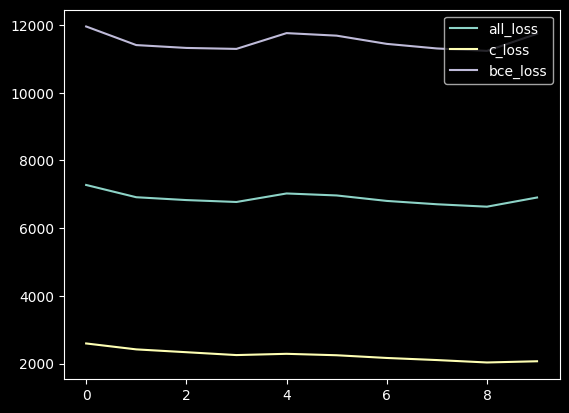

In [49]:
#绘制损失曲线
plt.plot(all_loss, label='all_loss')
plt.plot(c_loss, label='c_loss')
plt.plot(b_loss, label='bce_loss')
plt.legend()
plt.show()